In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec, SpectralMixtureComponent
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
from bnqdflow.effect_size_measures import MAE
sns.set(style='whitegrid')
np.random.seed(1)

### Load data

In [2]:
def load_data(record):
    x1, x2 = [], []
    y1, y2 = [], []

    # Pre meditation 
    with open('datasets/heart-rate-oscillations-during-meditation-1.0.0/data/'+record[1], 'r') as file:
        for line in file:
            x, y = line.strip().split()
            x, y = np.float32(x), np.float32(y) 
            x1.append(x)
            y1.append(y)
    x1 = np.array(x1)
    y1 = np.array(y1)

    # During medition
    with open('datasets/heart-rate-oscillations-during-meditation-1.0.0/data/'+record[0], 'r') as file:
        for line in file:
            x, y = line.strip().split()
            x, y = np.float32(x), np.float32(y) 
            x2.append(x)
            y2.append(y)
    x2 = np.array(x2)
    y2 = np.array(y2)
    
    # Combined time series
    δ   = x2[0]- x1[-1]
    x2 -= δ
    X   = np.append(x1, x2)
    Y   = np.append(y1, y2)
    b   = x1[-1]
    
    return X, Y, b

def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

    
def plot_data(X, Y, b, y_lim=(40,150), title='Combined meditation data'):
    fig = plt.figure(figsize=(15,6))
    plt.plot(X, Y, label='meditation chi',color='k')
    plt.axvline(b, color='k', linestyle='--')
    plt.title(title)
    plt.legend(loc='best')
    #plt.ylim(y_lim[0],y_lim[1])
    plt.show()

(1584,) (1584,)


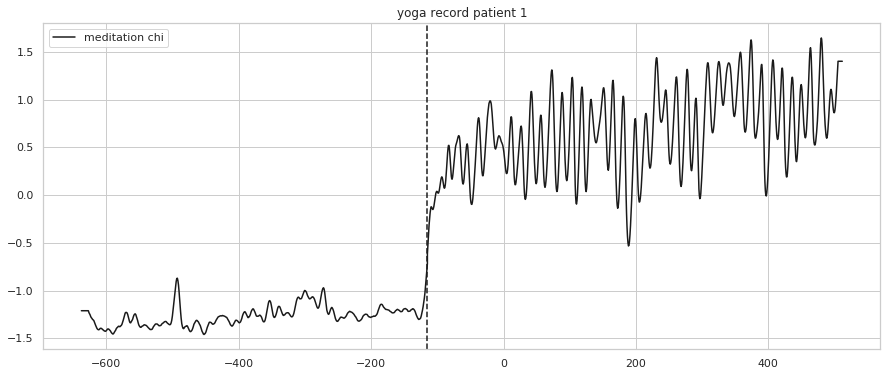

(1860,) (1860,)


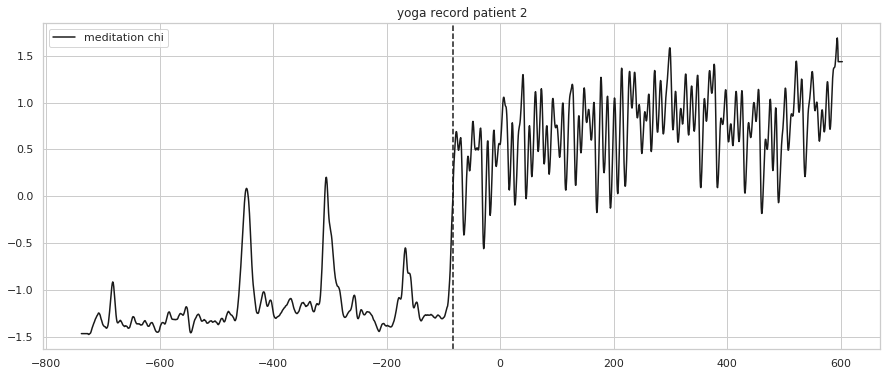

(1630,) (1630,)


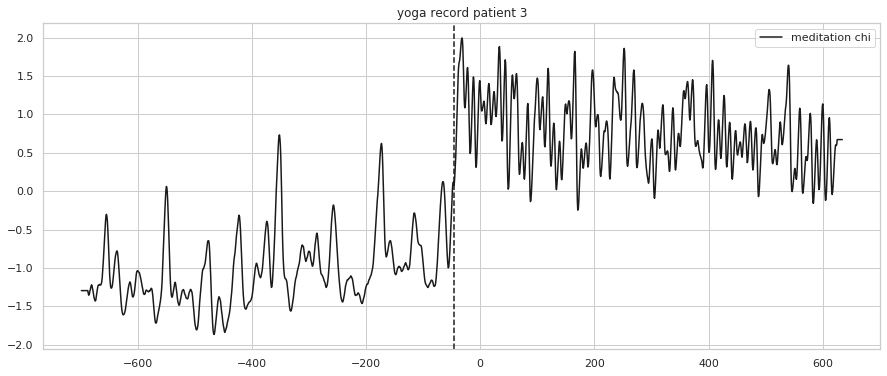

(1384,) (1384,)


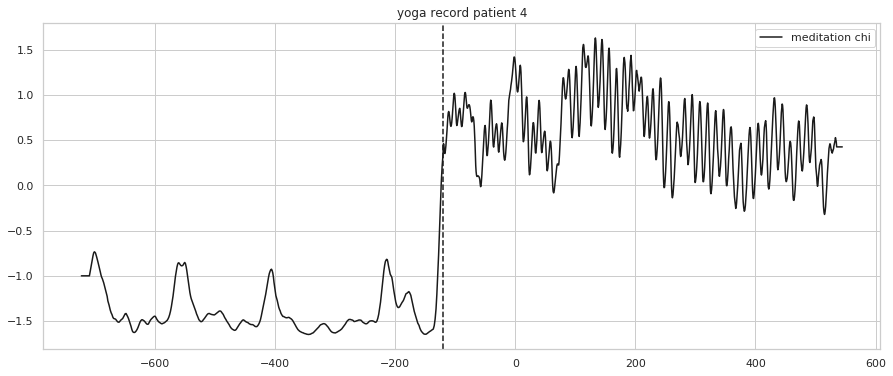

In [3]:
folders = ['yoga']
X = []
degree = 8

for folder in folders:    
    # Read records of a given dataset
    X_f = [] # All data of a folder
    records = []
    with open('datasets/heart-rate-oscillations-during-meditation-1.0.0/data/'+folder+'/RECORDS', 'r') as file:
        for line in file:
            name = line.strip()
            name = folder+'/'+name[:2]+'.'+name[2:]
            records.append(name)
    records = np.array(records)
    records = records.reshape(int(records.shape[0]/2),2) # (n_patients, 2)
    
    # Read in data set
    X_i = [] # Dataset of a patient
    for i, patient in enumerate(records):
        X_i, Y_i, b_i = load_data(records[i])
        print(X_i.shape,Y_i.shape)

        # Apply triangular smoothing window
        Y_i = np.array(smoothTriangle(Y_i, degree))
        

        # Standardize data
        control_idx, int_idx = X_i<b_i, X_i>=b_i
        zscorey = lambda y: (y - np.mean(Y_i)) / np.std(Y_i)
        zscorex = lambda x: (x - np.mean(X_i)) / np.std(X_i)       
        
        μ_xi, σ_xi = np.mean(X_i), np.std(X_i)
        μ_yi, σ_yi = np.mean(Y_i), np.std(Y_i)
        norm = [μ_yi, σ_yi, μ_xi, σ_xi]
        
       
        Y_i = zscorey(Y_i)
        
        #b_i = zscorex(b_i)
        #X_i = zscorex(X_i)
        b_i = b_i - np.mean(X_i)
        X_i = X_i - np.mean(X_i)
        plot_data(X_i, Y_i, b_i, title=f'{folder} record patient {i+1}')
        X_f.append(np.array([X_i,Y_i,b_i, norm]))

    X_f = np.array(X_f) 
    X.append(X_f)
X = np.array(X)

## Periodogram for comparison


(4,)
Patient 1


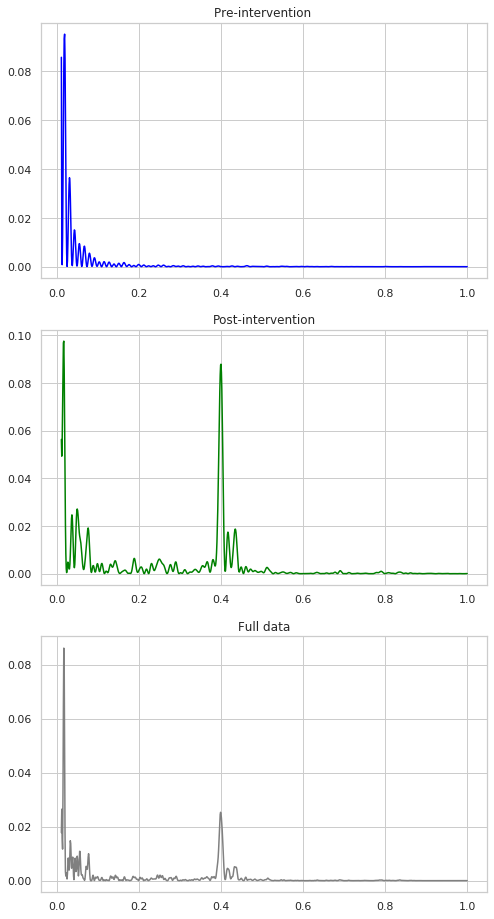

(4,)
Patient 2


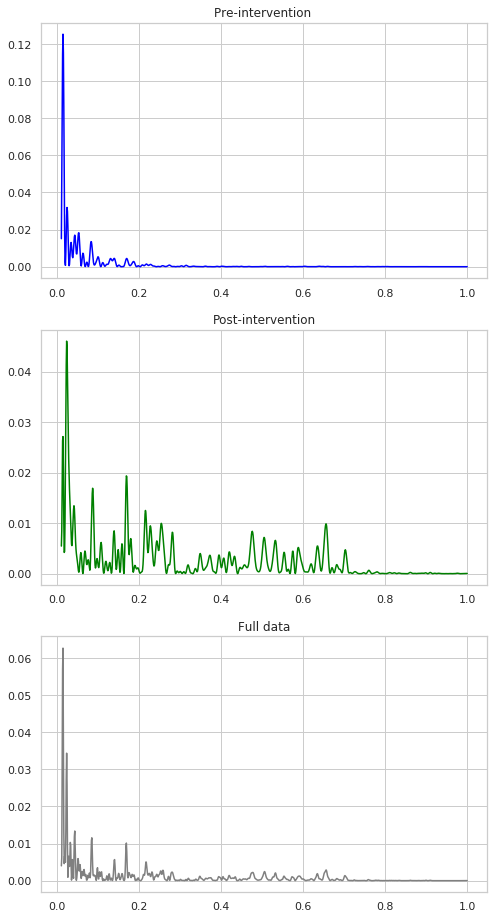

(4,)
Patient 3


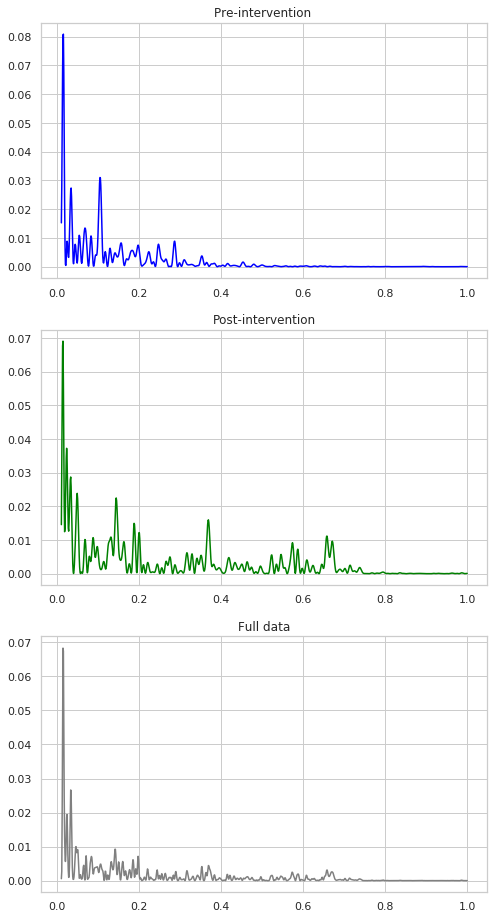

(4,)
Patient 4


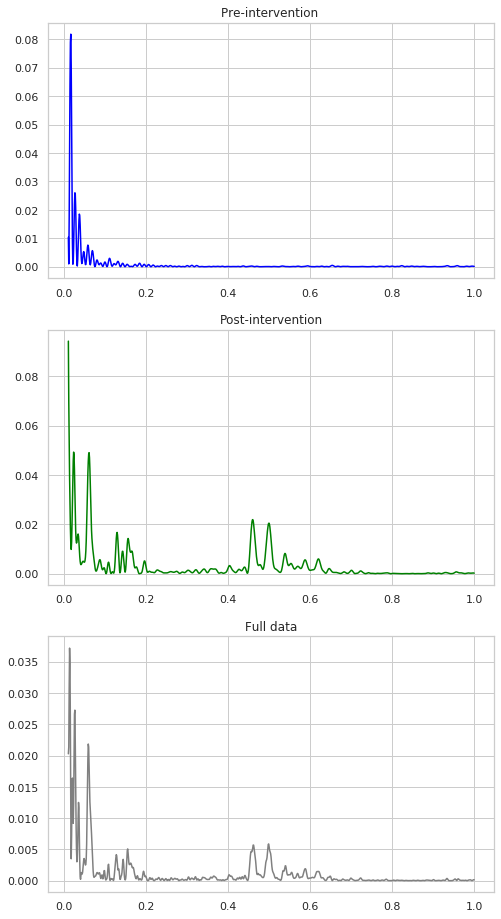

In [4]:
import scipy.signal as signal
for p, patient in enumerate(X[0]):
    print(patient.shape)
#     if p is not 1:
#         continue
    X_i, Y_i, b_i,norm = patient
    μ_yi, σ_yi, μ_xi, σ_xi = norm
    
    
    x1, x2 = np.float64(X_i[X_i<b_i]), np.float64(X_i[X_i>=b_i])
    y1, y2 = np.float64(Y_i[:len(x1)]), np.float64(Y_i[len(x1):])
    fig, ax = plt.subplots(3,1, figsize=(8,16))
    freqs = np.linspace(0.01, 1., 1000)

    print(f'Patient {p+1}')
    # Plot lomb scargle periodogram
    Pxx = signal.lombscargle(x1, y1, freqs, normalize=True)
    ax[0].plot(freqs, Pxx, color='blue')
    ax[0].set_title('Pre-intervention ')
    Pxx = signal.lombscargle(x2, y2, freqs, normalize=True)
    ax[1].plot(freqs, Pxx, color='green')
    #ax[1].set_ylim((0,0.2))
    ax[1].set_title('Post-intervention')
    Pxx = signal.lombscargle(X_i, Y_i, freqs, normalize=True)
    ax[2].plot(freqs, Pxx,color='grey')
    ax[2].set_title('Full data')
    plt.show()

(719,) (911,) (719,) (911,) (1630,) (1630,)
6 2 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒═════════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                                                            │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │ value                

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒═══════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                                          │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════════════════════════════════════════╪═════

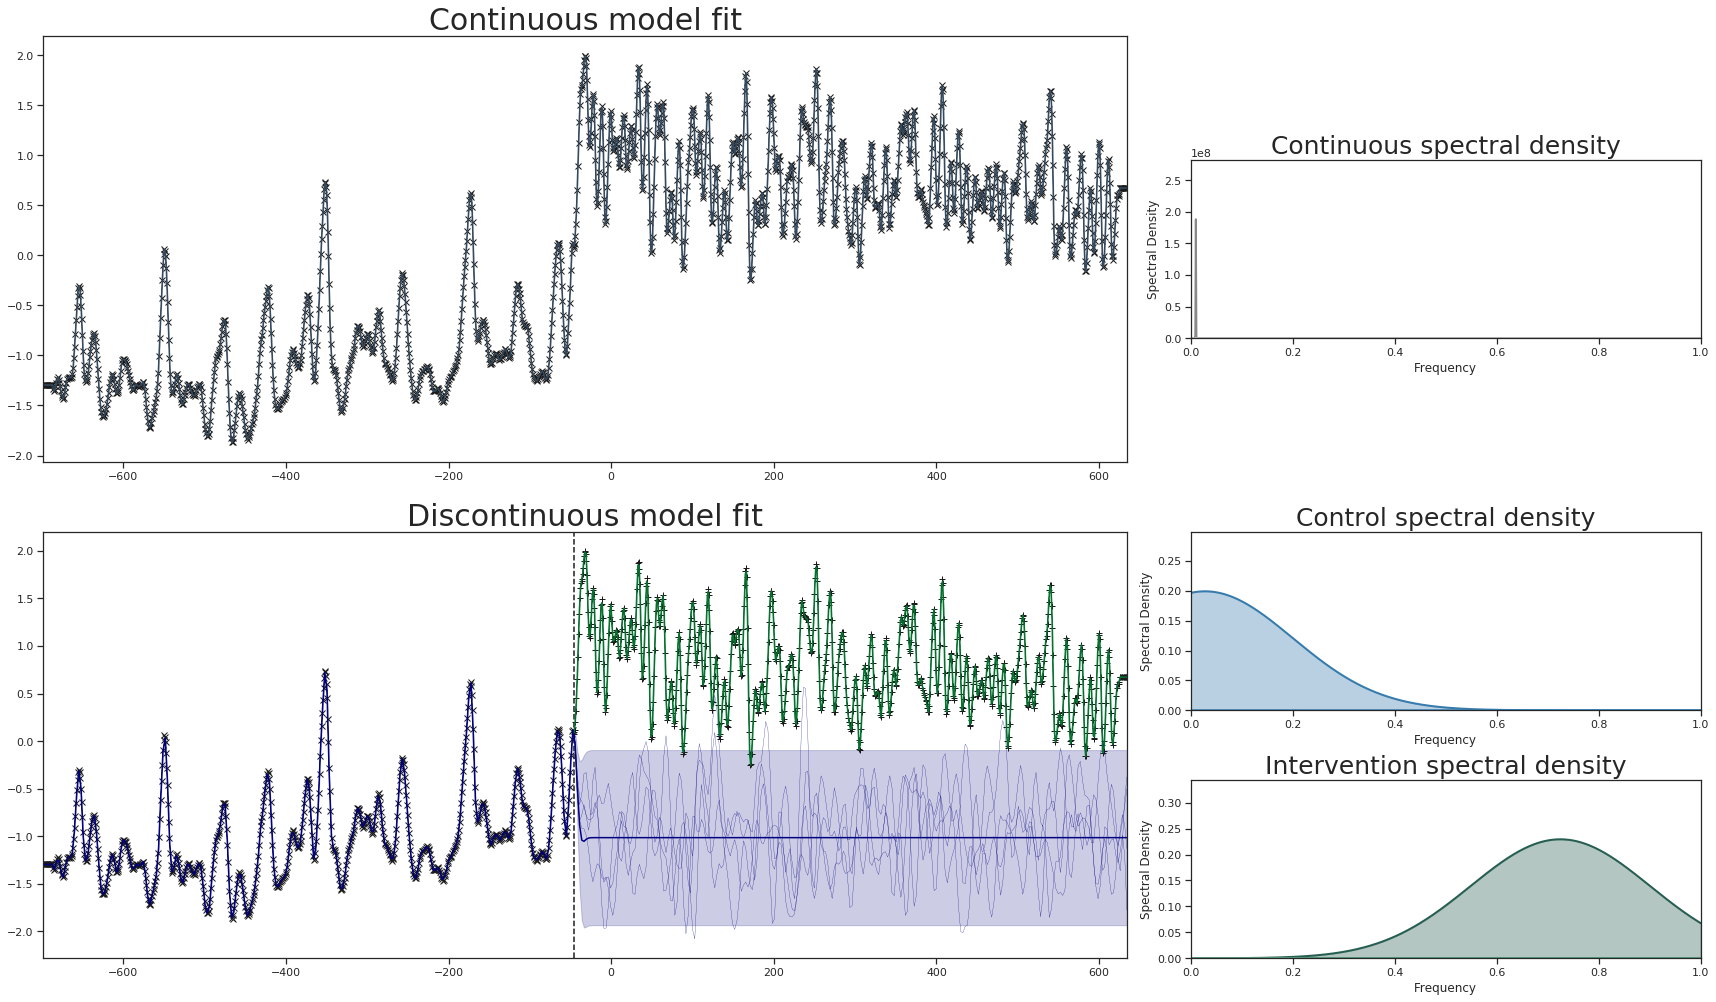

[  0.          0.        319.4217279   0.       ]
[0.         0.         1.79382655 0.        ]


In [9]:
## Run SM analyses
# yoga patients
bayes_factors, effect_sizes  = np.zeros((X[0].shape[0])), np.zeros((X[0].shape[0]))
for p, patient in enumerate(X[0]):
    # Run analyses 1 by 1 to prevent running out of memory
    if p is not 2:
        continue
    X_i, Y_i, b_i,norm = patient

    μ_yi, σ_yi, μ_xi, σ_xi= norm 
    x1, x2 = np.float64(X_i[X_i<b_i]), np.float64(X_i[X_i>=b_i])
    y1, y2 = np.float64(Y_i[:len(x1)]), np.float64(Y_i[len(x1):])
    
    print(x1.shape, x2.shape,y1.shape,y2.shape,X_i.shape,Y_i.shape)
    # # Save data of model
    np.save('data', np.array([X_i,Y_i,b_i]))
    np.save('standardization_terms', np.array([μ_yi, σ_yi]))

    dummy_kernel    = Linear()
    a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], dummy_kernel, b_i, share_params=False)

    constant1, constant2 = Constant(), Constant()
    changepoints         = ChangePoints([constant1, constant2], locations=[b_i], steepness=99999.0)
    gpflow.set_trainable(changepoints.locations, False)

     # Determine for each model the number of components
    min_Q, max_Q   = 2, 10
    fs             = .6
    Q_continuous   = 6#t.find_optimal_Q(X_i,Y_i,a.continuous_data, min_Q, max_Q, fs=fs, added_kernel = None) # To do: find a way to specify the prior outside of the toolbox.
    Q_control      = 2#t.find_optimal_Q(x1, y1, a.discontinuous_data[0], min_Q, max_Q, fs=fs, added_kernel = Constant())
    Q_intervention = 3#t.find_optimal_Q(x2, y2, a.discontinuous_data[1], min_Q, max_Q, fs=fs, added_kernel = Constant()) 
    print(Q_continuous, Q_control, Q_intervention)
    
    sm_continuous   = SpectralMixture(Q_continuous, x=X_i,y=Y_i,fs=fs) + changepoints
    sm_control      = SpectralMixture(Q_control, x=x1, y=y1, fs=fs) + Constant()
    sm_intervention = SpectralMixture(Q_intervention, x=x2, y=y2, fs=fs) + Constant()


    # Assign priors to kernels
    kernels = [sm_continuous, sm_control, sm_intervention]
    for kernel in kernels:
        for k in kernel.kernels:
            if isinstance(k, SpectralMixtureComponent):
                continue #k.lengthscale.prior = tfd.Gamma(f64(8.), f64(.6))         

    # Run analysis
    a.continuous_model.models[0].kernel    = sm_continuous
    a.discontinuous_model.models[0].kernel = sm_control
    a.discontinuous_model.models[1].kernel = sm_intervention
    a.train(verbose=True)

    # Save results
    log_bayes_factor = a.log_bayes_factor(verbose=True)
    bayes_factors[p] = log_bayes_factor.numpy()
    causal_effects, average_es, sum_es = a.get_effect_size(MAE())
    effect_sizes[p] = average_es
    np.save('causal_effects', causal_effects)
    np.save('bayes_factor', bayes_factors)
    np.save('Q_values', np.array([Q_continuous, Q_control, Q_intervention]))
    
    # Plot model fits
    t.plot_posterior_model_spectrum(a, padding=0, max_x = 2.5,lineplot=False, scalar = 1, num_samples=X_i.shape[0], num_f_samples=4)
    plt.show()
        
print(bayes_factors)
print(effect_sizes)


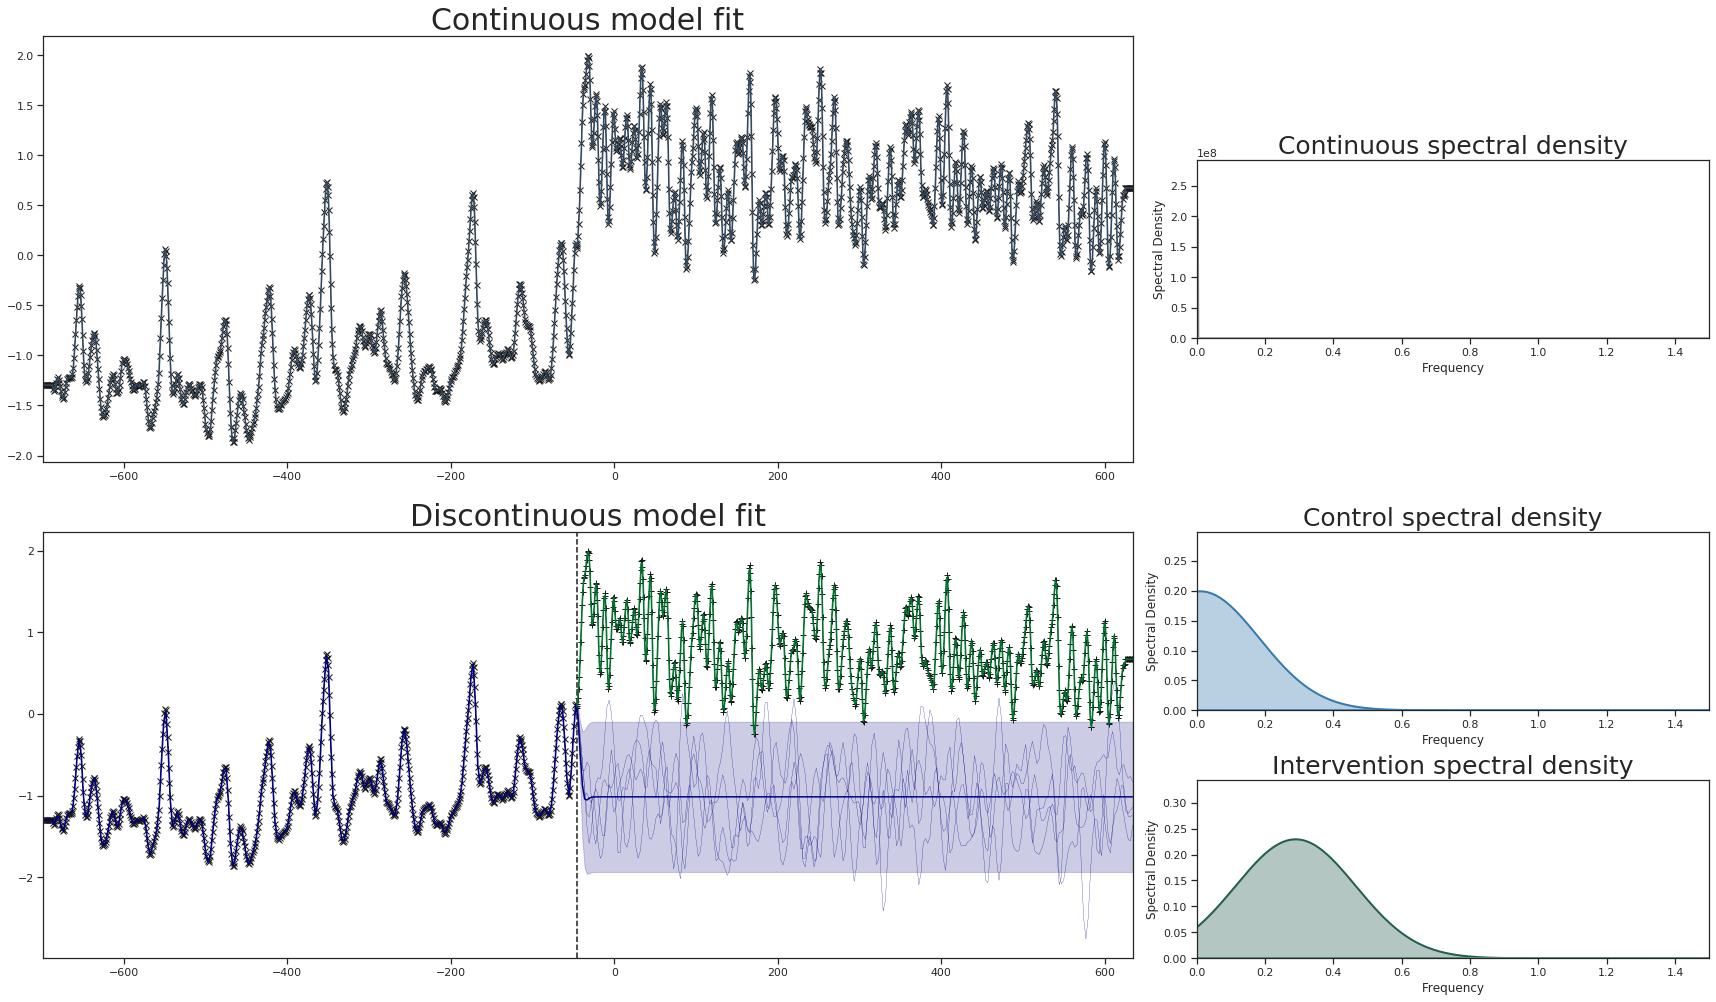

In [11]:
# Plot model fits
t.plot_posterior_model_spectrum(a, padding=0, max_x = 1.5,lineplot=False, scalar = 1, num_samples=X_i.shape[0], num_f_samples=4)
plt.show()

In [6]:
# t.plot_posterior_model_spectrum(a, padding=0, max_x = 1.5,lineplot=True, scalar = 1,num_f_samples=4, num_samples=X_i.shape[0], predict_y=False)
# plt.show()

In [7]:
# ## Run SM analyses
# # not yoga patients
# bayes_factors = np.zeros((X[1].shape[0], 11))
# for p, patient in enumerate(X[1]):
# #     if p is not 1:
# #         continue
#     X_i, Y_i, b_i, norm = patient
#     μ_yi, σ_yi,, μ_xi, σ_xi= norm 
#     x1, x2 = np.float64(X_i[X_i<b_i]), np.float64(X_i[X_i>=b_i])
#     y1, y2 = np.float64(Y_i[:len(x1)]), np.float64(Y_i[len(x1):])
#     print(x1.shape, x2.shape,y1.shape,y2.shape,X_i.shape,Y_i.shape)
  
#     for Q in range(5,6):
#         dummy_kernel    = Linear()
#         a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], dummy_kernel, b_i, share_params=False)
        
#         sm_continuous   = SpectralMixture(Q, x=X_i,y=Y_i,fs=.6) + Constant()
#         sm_control      = SpectralMixture(Q, x=x1, y=y1, fs=.6) + Constant()
#         sm_intervention = SpectralMixture(Q, x=x2, y=y2, fs=.6) + Constant()
        
#         a.continuous_model.models[0].kernel    = sm_continuous
#         a.discontinuous_model.models[0].kernel = sm_control
#         a.discontinuous_model.models[1].kernel = sm_intervention

        
#         a.train(verbose=False)
#         log_bayes_factor = a.log_bayes_factor(verbose=True)
#         #bayes_factors[p,i-1] = log_bayes_factor.numpy()
#         t.plot_posterior_model_spectrum(a, Q, padding=0, max_x = 0.9,lineplot=False, scalar = 2*np.pi, num_f_samples=4)
#         plt.show()
        
        
# # for i in range(11):
# #     print(bayes_factors[i,:])